# Movie rating Recommendation system

## Business and Data Understanding

## Data Preparartion

 I'll start by inspecting the contents of these files to understand their structure and proceed with building the movie recommendation system.

In this project, we have 3 seperate datasets
* Links dataset
* Movies dataset
* Ratings dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
links_df = pd.read_csv('./ml-latest-small/links.csv')
movies_df = pd.read_csv('./ml-latest-small/movies.csv')
ratings_df = pd.read_csv('./ml-latest-small/ratings.csv')


In [3]:
# print the head of each dataset

links_df_head = links_df.head()
movies_df_head = movies_df.head()
ratings_df_head = ratings_df.head()

links_df_head, movies_df_head, ratings_df_head

(   movieId  imdbId   tmdbId
 0        1  114709    862.0
 1        2  113497   8844.0
 2        3  113228  15602.0
 3        4  114885  31357.0
 4        5  113041  11862.0,
    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  ,
    userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  964983815
 4       1       50  

Here is the structure of the three datasets:

    1. Links Dataset (links.csv):
        * movieId: A unique identifier for each movie (linked to the movies.csv dataset).
        * imdbId: The IMDb ID for the movie.
        * tmdbId: The TMDb ID for the movie.
     
    2. Movies Dataset (movies.csv):
    
        * movieId: A unique identifier for each movie (linked to the ratings.csv and links.csv datasets).
        * title: The title of the movie, including the release year.
        * genres: The genres associated with the movie (separated by "|").

    3.Ratings Dataset (ratings.csv):

        * userId: A unique identifier for each user.
        * movieId: A unique identifier for the movie (linked to the movies.csv dataset).
        * rating: The rating given by the user (on a scale, e.g., 1 to 5).
        * timestamp: The timestamp of when the rating was given.

## EDA

I'll focus on the following for EDA:

    1. Missing Values: Check for null or missing values in each dataset.
    
    2. Distribution of Ratings: Analyze the distribution of ratings to understand user behavior.
    
    3. Movie Statistics: Identify the most-rated and least-rated movies.
    
    4. User Statistics: Understand user activity (e.g., number of movies rated per user).
    
    5. Genre Analysis: Explore the genres of movies to see the diversity in the dataset.

In [4]:
# Check for missing values in each dataset

missing_links = links_df.isnull().sum()

missing_movies = movies_df.isnull().sum()

missing_ratings = ratings_df.isnull().sum()



missing_links, missing_movies, missing_ratings

(movieId    0
 imdbId     0
 tmdbId     8
 dtype: int64,
 movieId    0
 title      0
 genres     0
 dtype: int64,
 userId       0
 movieId      0
 rating       0
 timestamp    0
 dtype: int64)

We see  the missing values in the following

    Links Dataset:
        tmdbId: 8 missing values.
We can drop these values since it's a small portion of missing values throughout the data

In [5]:
links_df.dropna(subset=['tmdbId'], inplace=True)

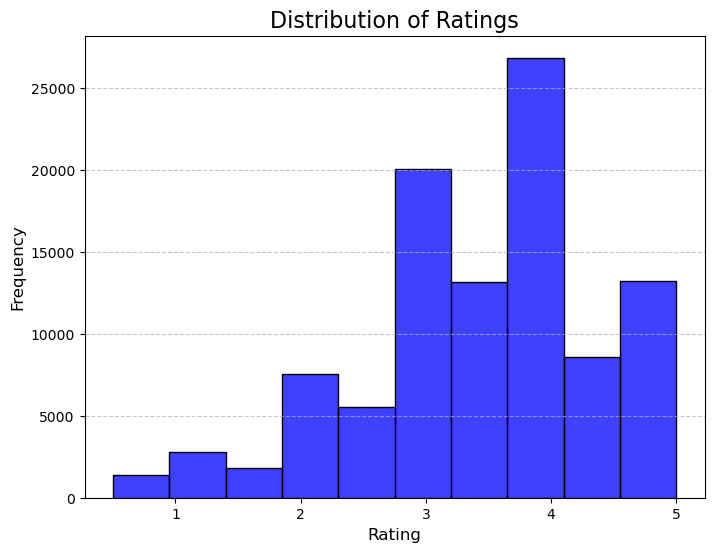

In [6]:
# Plot the distribution of ratings
plt.figure(figsize=(8, 6))
sns.histplot(ratings_df['rating'], bins=10, kde=False, color='blue')
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The distribution of ratings shows clear peaks at rounded values (e.g., 3.0, 4.0, 5.0), suggesting users prefer whole-number ratings. The majority of ratings seem to lean towards higher values, indicating that users may tend to rate movies positively.

In [8]:
# Movie statistics: Number of ratings per movie
movie_rating_counts = ratings_df['movieId'].value_counts()
most_rated_movies = movie_rating_counts.head(5)
least_rated_movies = movie_rating_counts.tail(5)

# Merge with movies_df to get movie titles for the most/least-rated movies
most_rated_movies_df = movies_df[movies_df['movieId'].isin(most_rated_movies.index)]
most_rated_movies_df = most_rated_movies_df.set_index('movieId').loc[most_rated_movies.index]
most_rated_movies_df['rating_count'] = most_rated_movies.values

#Least-rated movies
least_rated_movies_df = movies_df[movies_df['movieId'].isin(least_rated_movies.index)]
least_rated_movies_df = least_rated_movies_df.set_index('movieId').loc[least_rated_movies.index]
least_rated_movies_df['rating_count'] = least_rated_movies.values

print('Most Rated Movies:')
print(most_rated_movies_df)

print('\n Least Rated Movies:')
print(least_rated_movies_df)


Most Rated Movies:
                                    title                       genres  \
movieId                                                                  
356                   Forrest Gump (1994)     Comedy|Drama|Romance|War   
318      Shawshank Redemption, The (1994)                  Crime|Drama   
296                   Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller   
593      Silence of the Lambs, The (1991)        Crime|Horror|Thriller   
2571                   Matrix, The (1999)       Action|Sci-Fi|Thriller   

         rating_count  
movieId                
356               329  
318               317  
296               307  
593               279  
2571              278  

 Least Rated Movies:
                                               title          genres  \
movieId                                                                
86279                           Into Eternity (2010)     Documentary   
86922    Nothing to Declare (Rien à déclarer) (2010)    

Let's visualize the Top 5 Most rated Movies

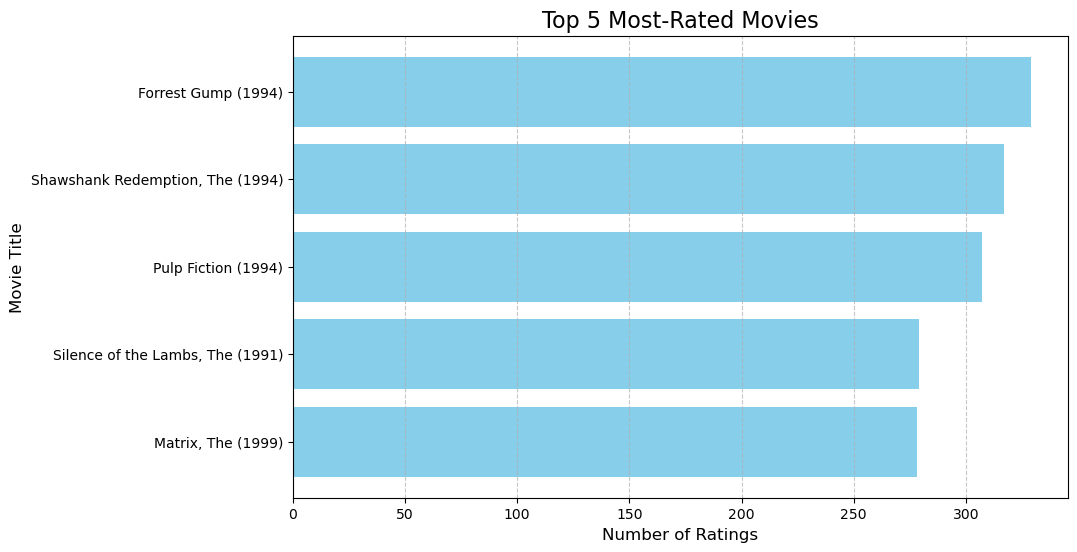

In [9]:
# Plot most-rated movies
plt.figure(figsize=(10, 6))
plt.barh(most_rated_movies_df['title'], most_rated_movies_df['rating_count'], color='skyblue')
plt.title('Top 5 Most-Rated Movies', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have the most-rated movie on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


Let's do the same with the 5 least rated movies

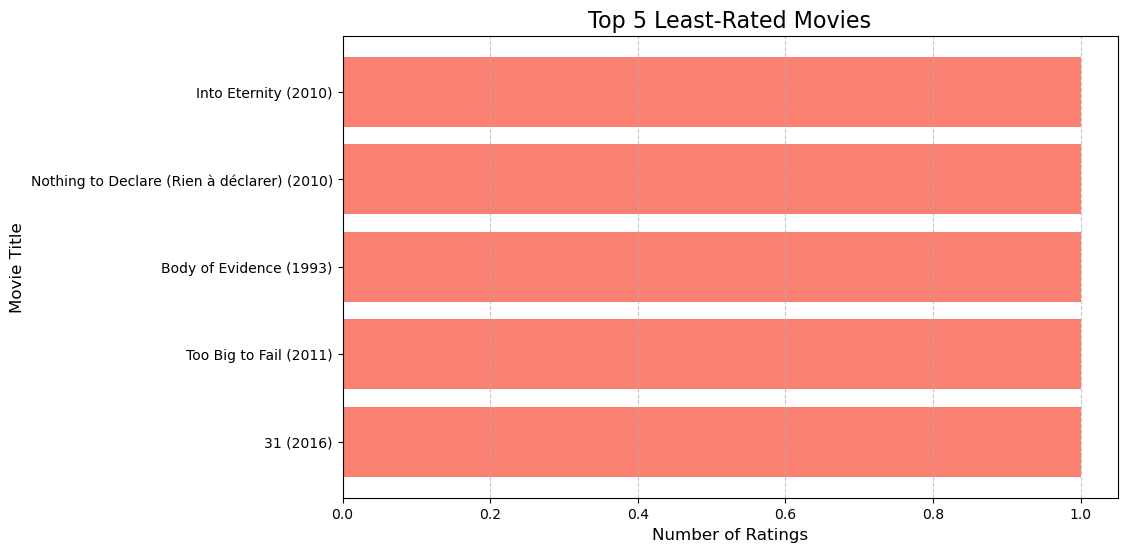

In [11]:
# Plot least-rated movies
plt.figure(figsize=(10, 6))
plt.barh(least_rated_movies_df['title'], least_rated_movies_df['rating_count'], color='salmon')
plt.title('Top 5 Least-Rated Movies', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have the least-rated movie on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


## Modeling

## Evaluation